In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from pandas.io.json import json_normalize
from pandas import json_normalize
# from pandas.io.json import json_normalize
from FCPython import createPitch
import json

In [2]:
#Function for finding passes before shot
shot_window = 15    
def in_range(pass_time,start,finish):
        return (True in ((start < pass_time) & (pass_time < finish)).unique())

#Size of the pitch in yards (!!!)
pitchLengthX=120
pitchWidthY=80

#Load the competition file
#Got this by searching 'how do I open json in Python'
with open('../static/data/Statsbomb/data/competitions.json', encoding="utf-8") as f:
    competitions = json.load(f)
    

In [3]:
#Womens World Cup 2019 has competition ID 72
# competition_id=72
competition_id=11
season_ids = [42, 4, 1]

matches = []
for season_id in season_ids:
    #Load the list of matches for this competition
    with open('../static/data/Statsbomb/data/matches/'+str(competition_id)+'/'+str(season_id)+'.json', encoding="utf-8") as f:
    # with open('Statsbomb/data/matches/'+str(competition_id)+'/30.json', encoding="utf-8") as f:
        matches = matches + json.load(f)

#Get all the teams and match_ids
teams=[]
match_ids=[]
for match in matches:
    if not(match['home_team']['home_team_name'] in teams):
        teams = teams + [match['home_team']['home_team_name']]
    if not(match['away_team']['away_team_name'] in teams):
        teams = teams + [match['away_team']['away_team_name']]

    match_ids=match_ids + [match['match_id']]


In [4]:
#Collect passes and shots for all players.
passshot_df = pd.DataFrame(None)
passshot_df = pd.DataFrame(columns=['Team','Passes','Shots','Goals','Matches','Danger Passes'])
danger_passes_by=dict()
number_of_matches=dict()
for match in matches:
    match_id=match['match_id']
    file_name=str(match_id)+'.json'
    with open('../static/data/Statsbomb/data/events/'+file_name, encoding="utf-8") as data_file:
        data = json.load(data_file)
    dfall = json_normalize(data, sep = "_").assign(match_id = file_name[:-5])
    
    print(match['home_team']['home_team_name'] + ' vs ' + match['away_team']['away_team_name'])
    
    #Home team
    for theteam in [match['home_team']['home_team_name'],match['away_team']['away_team_name']]:
        team_actions = (dfall['team_name']==theteam)
        df = dfall[team_actions]
        #A dataframe of passes
        passes_match = df.loc[df['type_name'] == 'Pass'].set_index('id')
        #A dataframe of shots
        shots_match = df.loc[df['type_name'] == 'Shot'].set_index('id')

        #Find passes within 15 seconds of a shot, exclude corners.
        shot_times = shots_match['minute']*60+shots_match['second']
        shot_start = shot_times - shot_window
        pass_times = passes_match['minute']*60+passes_match['second']
        pass_to_shot = pass_times.apply(lambda x: in_range(x,shot_start,shot_times))
        iscorner = passes_match['pass_type_name']=='Corner'
        danger_passes=passes_match[np.logical_and(pass_to_shot,np.logical_not(iscorner))]
        if theteam in danger_passes_by:
            danger_passes_by[theteam]= danger_passes_by[theteam].append(danger_passes)
            number_of_matches[theteam]=number_of_matches[theteam]+1
        else:
            danger_passes_by[theteam]= danger_passes
            number_of_matches[theteam]=1
            
        if theteam==match['home_team']['home_team_name']:
            goalsscored=match['home_score']
        else:
            goalsscored=match['away_score']
            
        passshot_df = passshot_df.append({
                    "Team": theteam,
                    "Passes": len(passes_match),
                    "Shots": len(shots_match),
                    "Goals": goalsscored,
                    "Danger Passes": len(danger_passes)
                    },ignore_index=True)       

Deportivo Alavés vs Barcelona
Barcelona vs Athletic Bilbao
Celta Vigo vs Barcelona
Real Valladolid vs Barcelona
Barcelona vs Leganés
Valencia vs Barcelona
Barcelona vs Osasuna
Barcelona vs Real Sociedad
Barcelona vs Espanyol
Barcelona vs Atlético Madrid
Real Sociedad vs Barcelona
Barcelona vs Real Madrid
Barcelona vs Celta Vigo
Barcelona vs Real Valladolid
Mallorca vs Barcelona
Barcelona vs Sevilla
Barcelona vs Granada
Espanyol vs Barcelona
Barcelona vs Villarreal
Sevilla vs Barcelona
Real Madrid vs Barcelona
Eibar vs Barcelona
Real Betis vs Barcelona
Granada vs Barcelona
Villarreal vs Barcelona
Levante vs Barcelona
Leganés vs Barcelona
Barcelona vs Getafe
Atlético Madrid vs Barcelona
Barcelona vs Mallorca
Barcelona vs Deportivo Alavés
Barcelona vs Levante
Barcelona vs Eibar
Barcelona vs Valencia
Barcelona vs Leganés
Real Betis vs Barcelona
Barcelona vs Atlético Madrid
Barcelona vs Real Betis
Barcelona vs Levante
Barcelona vs Villarreal
Girona vs Barcelona
Deportivo Alavés vs Barcelona

                            OLS Regression Results                            
Dep. Variable:                  Shots   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     44.91
Date:                Mon, 05 Apr 2021   Prob (F-statistic):           1.98e-10
Time:                        18:37:52   Log-Likelihood:                -598.60
No. Observations:                 206   AIC:                             1201.
Df Residuals:                     204   BIC:                             1208.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.5757      0.960      6.850      0.0

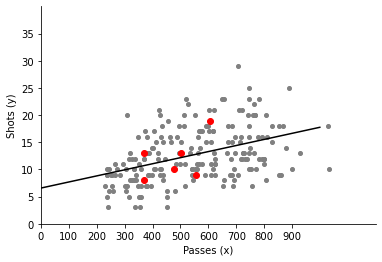

In [19]:
#Plot passes vs. shots. 
fig,ax=plt.subplots(num=1)
ax.plot('Passes','Shots', data=passshot_df, linestyle='none', markersize=4, marker='o', color='grey')
# team_of_interest="United States Women's"
# team_of_interest="England Women's"
team_of_interest="Real Sociedad"
team_of_interest_matches=(passshot_df['Team']==team_of_interest)
ax.plot('Passes','Shots', data=passshot_df[team_of_interest_matches], linestyle='none', markersize=6, marker='o', color='red')
ax.set_xticks(np.arange(0,1000,step=100))
ax.set_yticks(np.arange(0,40,step=5))
ax.set_xlabel('Passes (x)')
ax.set_ylabel('Shots (y)')

#Fit a straight line regression model for how number of passes predict number of shots from number of passes
import statsmodels.api as sm
import statsmodels.formula.api as smf
passshot_df['Shots']= pd.to_numeric(passshot_df['Shots']) 
passshot_df['Passes']= pd.to_numeric(passshot_df['Passes']) 
passshot_df['Goals']= pd.to_numeric(passshot_df['Goals']) 

#Fit the model
model_fit=smf.ols(formula='Shots ~ Passes', data=passshot_df[['Shots','Passes']]).fit()
print(model_fit.summary())        
b=model_fit.params
x=np.arange(0,1000,step=0.5)
y=b[0]+b[1]*x
ax.plot( x,y, linestyle='-', color='black')
ax.set_ylim(0,40)
# ax.set_xlim(0,800) 
ax.set_xlim(0,1200) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()
fig.savefig('../static/img/ShotsPassesWithFit_Real Sociedad.jpg', dpi=None, bbox_inches="tight") 

In [14]:
#For goals (and strictly speaking even for shots) it is better to do a Poisson regression
poisson_model = smf.glm(formula="Goals ~ Passes + Team", data=passshot_df,
                    family=sm.families.Poisson()).fit()
poisson_model.summary()
b=poisson_model.params

In [15]:
#Make comparative pass maps
x_all=[]
y_all=[]
H_Pass=dict()
for team in teams:
    dp=danger_passes_by[team]
    print(team + str(len(dp)))
    
    x=[]
    y=[]
    for i,apass in dp.iterrows():
        x.append(apass['location'][0])
        y.append(pitchWidthY-apass['location'][1])

    #Make a histogram of passes
    H_Pass[team]=np.histogram2d(y, x,bins=5,range=[[0, pitchWidthY],[0, pitchLengthX]])
    
    x_all = x_all+x
    y_all = y_all+y

H_Pass_All=np.histogram2d(y_all, x_all,bins=5,range=[[0, pitchWidthY],[0, pitchLengthX]])


Deportivo Alavés78
Barcelona4486
Athletic Bilbao116
Celta Vigo146
Real Valladolid108
Leganés147
Valencia128
Osasuna21
Real Sociedad206
Espanyol132
Atlético Madrid126
Real Madrid217
Mallorca53
Sevilla200
Granada24
Villarreal203
Eibar180
Real Betis116
Levante129
Getafe104
Girona94
Huesca21
Rayo Vallecano10
Málaga33
Las Palmas40
Deportivo La Coruna71


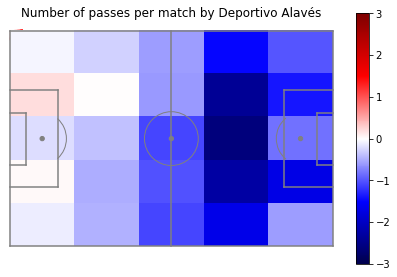

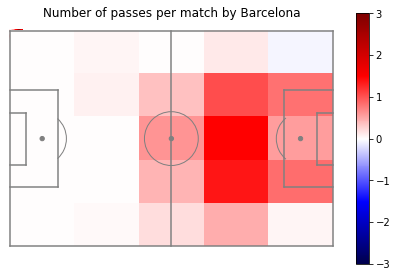

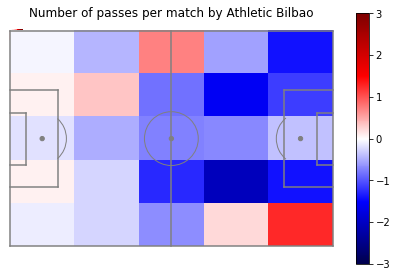

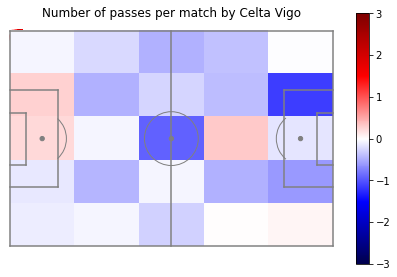

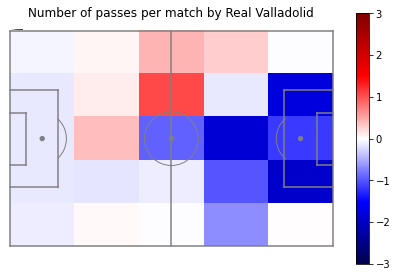

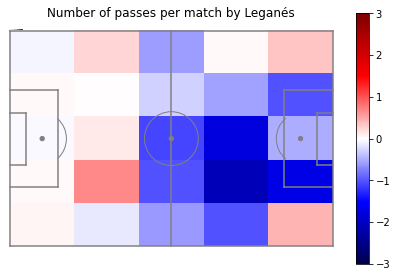

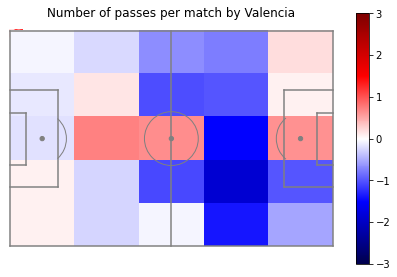

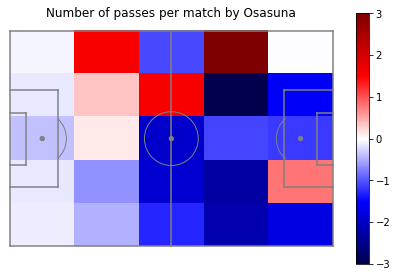

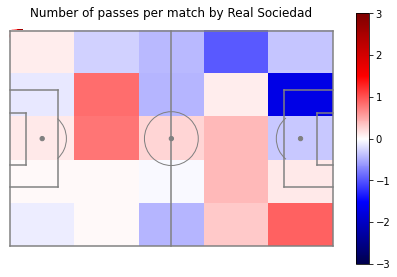

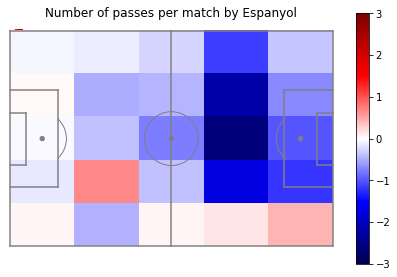

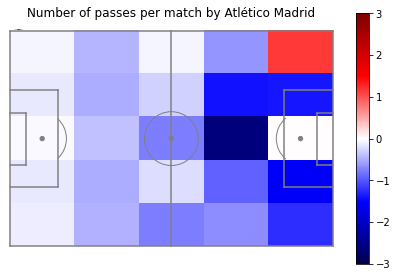

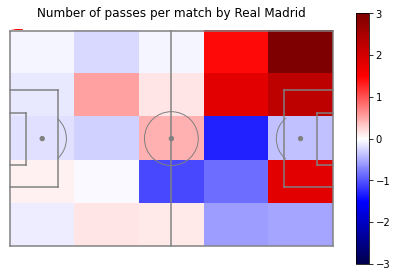

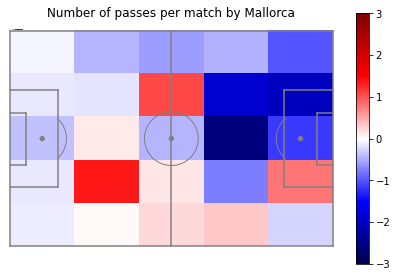

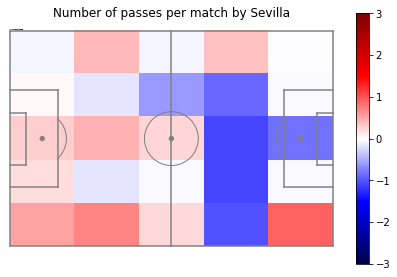

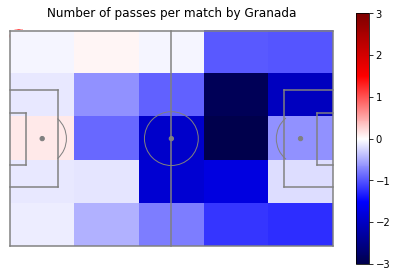

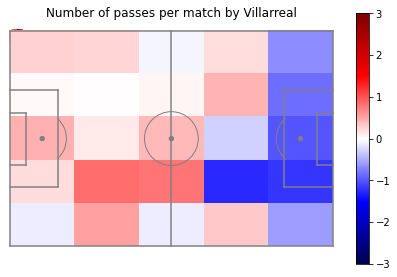

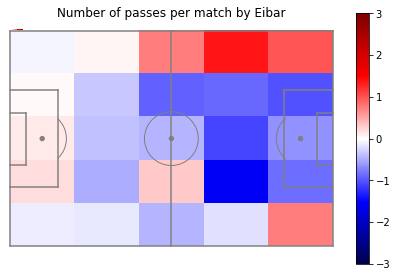

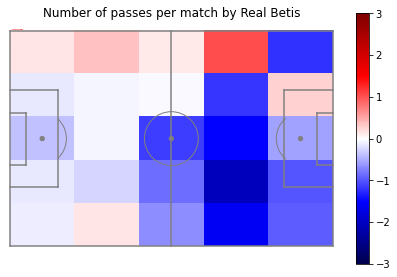

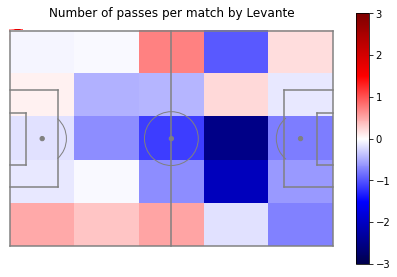

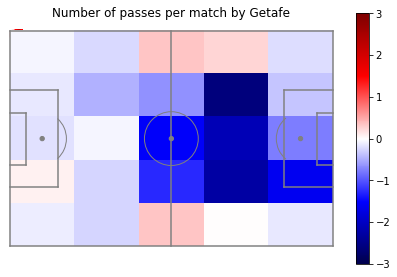

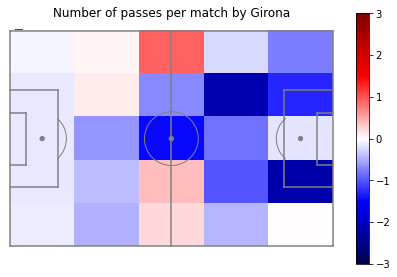

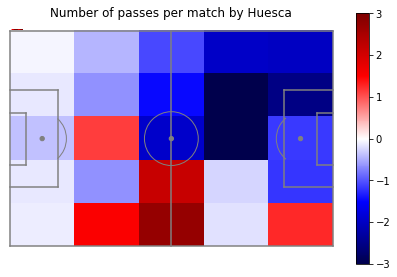

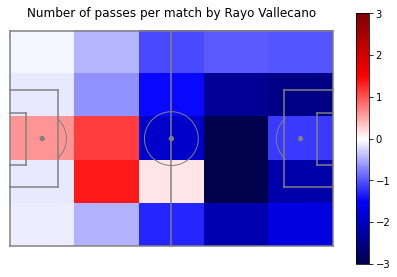

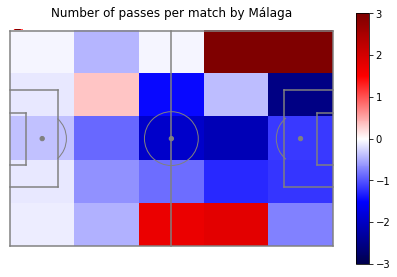

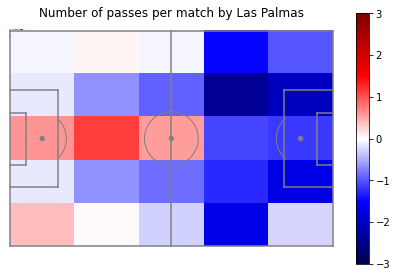

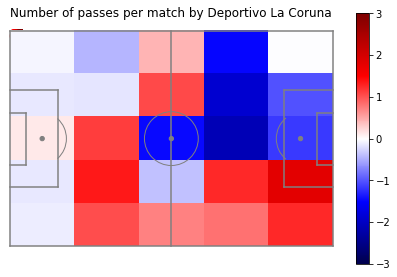

In [16]:
#Compare to mean
for team in teams:
    (fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','gray')
    pos=ax.imshow(H_Pass[team][0]/number_of_matches[team], aspect='auto',cmap=plt.cm.seismic,vmin=-3, vmax=3)
    pos=ax.imshow(H_Pass[team][0]/number_of_matches[team] - H_Pass_All[0]/(len(matches)*2), extent=[0,120,0,80], aspect='auto',cmap=plt.cm.seismic,vmin=-3, vmax=3)
    #pos=ax.imshow(H_Pass[team][0]/number_of_matches[team] / (H_Pass_All[0]/(len(matches)*2)), extent=[0,120,0,80], aspect='auto',cmap=plt.cm.seismic,vmin=0.5, vmax=2)
    
    ax.set_title('Number of passes per match by ' +team)
    plt.xlim((-1,121))
    plt.ylim((83,-3))
    plt.tight_layout()
    plt.gca().set_aspect('equal', adjustable='box')
    fig.colorbar(pos, ax=ax)
    plt.show()
    
    fig.savefig('../static/img//PassHeat' + team+ '.jpg', dpi=None, bbox_inches="tight")